# Overall Setup [no changes]

Install dependancies and functions for displaying videos

Setup code source: StarAI



In [134]:
#CELL 1
#remove " > /dev/null 2>&1" to see what is going on under the hood
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [135]:
#CELL 2
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[box2d] > /dev/null 2>&1

Requirement already up-to-date: setuptools in /usr/local/lib/python3.6/dist-packages (50.3.2)


In [136]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

#CELL 3

In [137]:
from pyvirtualdisplay import Display
#CELL 4

display = Display(visible=0, size=(1400, 900))
display.start()

In [138]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""
#CELL 5

def show_video(folder):
  mp4list = glob.glob(folder+'/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env, folder):
  env = Monitor(env, './'+folder, force=True)
  return env

# Lunar Lander Setup! [no changes, but look at output]
For more information about the domain, visit
https://gym.openai.com/envs/LunarLander-v2/

In [139]:
#CELL 6
folder = 'video-test'
#create the lunar lander environment
env = wrap_env(gym.make("LunarLander-v2"),folder)

In [140]:
#CELL 7
#check out the lunar lander action space! 
#There are 8 states as defined in the GitHub, 6 of which are continuous and the final 2 are binary
print(env.observation_space.shape[0])
#There are 4 actions (fire the main engine, left engine, right engine, or do nothing)
print(env.action_space)

8
Discrete(4)


In [141]:
#CELL 8
#This is the baseline code to be able to implement the RL algorithms!
observation = env.reset()

while True:
    env.render()

    #your agent goes here
    action = env.action_space.sample()  #this is a random agent
         
    observation, reward, done, info = env.step(action) 
    
    if done: 
      break;        
env.close()
show_video(folder)

# Q-Learning Implementation

In [142]:
#CELL 9
#create the lunar lander environment

"""
TODO: Discretizing the continuous observation state space. The final two values
    are binary and therefore only have 2 values (0 or 1) but the other values 
    can be separated into any number of buckets (greater than 3).
    According to OpenAI "the useful range is -1 .. +1, but spikes can be higher"
"""
# translate

bucket_num = [16,16,5,5,5,5,2,2] #some default values! Set your own. 

def get_Q_state(state):
    """
    OPTIONAL: change the bucketing method!
    This method takes the state (a length 8 numpy array) from the environment
    and returns a string (the state string)encoding the discrete states 
    (formatted with dashes between values). 
    """
    assert(state.shape[0] == 8)

    bucket = [0. for index in range(8)]
    
    for index in range(8):
        if (index == 6 or index == 7):
            bucket[index] = int(state[index])
        else:
            # removed non-useful range (<-1 or >1)
            if (state[index] <= -1):
                bucket[index] = 0
            elif (state[index] >= 1):
                bucket[index] = bucket_num[index]-1
            else: #several uniform buckets for the other indexes
                bucket[index] = int((state[index]+2)*bucket_num[index]//4)
    # print(state)
    bucket_string = ""
    for index in range(8):
        bucket_string = bucket_string + str(bucket[index]) + "-"
    
    return bucket_string[:-1]

In [143]:
#CELL 10
import random
from IPython.display import clear_output
import pickle

folder = 'video-final'
env = wrap_env(gym.make("LunarLander-v2"),folder)

# initialise Q table to 0
q_table = {}

# Hyperparameters
alpha = 0.1
alpha_decay = 0.9
alpha_min = 0.0001
gamma = 0.99 
epsilon = 0.001 
epsilon_decay = 0.99
epsilon_min = 0.00001
episodes = 3000


# For plotting metrics
all_epochs = [] #store the number of epochs per episode
all_rewards = [] #store the penalties per episode

# get next optimal action function
def get_action(bucket_state):
  q_array = []
  # index into q table with state and action (iterating over 4 actions)
  for action in range(0, 3): 
    if (bucket_state, action) in q_table:
      q_array.append(q_table[(bucket_state, action)])
    else:
      q_array.append(0)
  maximum_value = max(q_array)
  return q_array.index(maximum_value)

for i in range(0, episodes):
    state = env.reset()
    epochs, total_reward = 0, 0
    # decay epsilon
    if epsilon > epsilon_min:
      epsilon = epsilon * epsilon_decay
    else:
      epsilon = epsilon_min
  
    # decay alpha
    if alpha > alpha_min:
      alpha = alpha * alpha_decay
    else:
      alpha = alpha_min
    
    done = False
    while not done:

        #get bucket state from q table
        bucket_state = get_Q_state(state)

        # choose action
        if random.random() < epsilon: 
          action = random.sample([0, 1, 2, 3], 1)[0] 
        else:
          action = get_action(bucket_state) 

        # feed into n.step function to give you new state, reward and flag
        next_state, reward, done, info = env.step(action) 

        next_bucket_state = get_Q_state(next_state)
           
        # use action and new state to update q table using q learning 
        if (bucket_state, action) in q_table:
          q_table[(bucket_state, action)] = q_table[(bucket_state, action)] + alpha * (reward + gamma * get_action(next_bucket_state) - q_table[(bucket_state, action)])
        else:
          q_table[(bucket_state, action)] = alpha * (reward + gamma * get_action(next_bucket_state))

        #S <-- S'
        state = next_state

        # Update counter
        epochs += 1
        total_reward += reward 

        # Until S is terminal
        if done:
          break;
        
    if i % 50 == 0:
        clear_output(wait=True)
    #print(f"Episode: {i},\t Epochs: {epochs},\tReward: {total_reward}")
    
    all_epochs.append(epochs)
    all_rewards.append(total_reward)

    if i % 1000 == 0: #adjust to save the q_table dictionary at checkpoints
        pickle.dump( q_table, open( "q_table.p", "wb" ) )

q_pair_num = (bucket_num[0]^6*2*2*4)*((sum(all_epochs)/len(all_epochs))/episodes)
print(f"Results for {q_pair_num} q values pairs:")
print("Training finished.\n")

Results for 3.9204106666666663 q values pairs:
Training finished.



In [144]:
#CELL 11
"""
Some sample code to help you evaluate agent's performance after Q-learning!
Adjust accordingly to generate some nice metrics. 
This code will not be graded.
"""
folder = 'video-eval'
env = wrap_env(gym.make("LunarLander-v2"),folder)
q_table = pickle.load( open( "q_table.p", "rb" ) )

total_epochs, total_reward = 0, 0
episodes = 100

for _ in range(episodes):
    state = env.reset()
    epochs, epoch_reward = 0, 0

    done = False
    
    while not done:
        state_string = get_Q_state(state)
        action = get_action(state_string)
        state, reward, done, info = env.step(action)

        epochs += 1
        epoch_reward += reward

    total_reward += epoch_reward
    total_epochs += epochs

print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average reward per episode: {total_reward / episodes}")

Results after 100 episodes:
Average timesteps per episode: 137.36
Average reward per episode: -393.91952875042654


In [145]:
#CELL 12
"""
TODO: Some sample code to help generate a video of a sample run! 
Adjust accordingly to generate some nice video files. 
This code will not be graded.
"""
folder = 'video-visual'
env = wrap_env(gym.make("LunarLander-v2"),folder)

state = env.reset()

while True:
    env.render()

    #your agent goes here
    state_string = get_Q_state(state)
    action = get_action(state_string)
    state, reward, done, info = env.step(action)
    
    if done: 
      break;        
env.close()
show_video(folder)


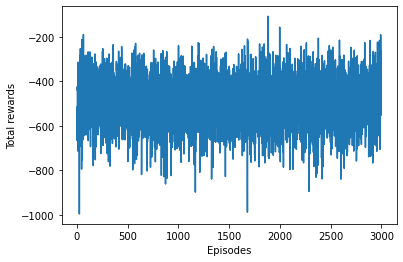

In [146]:
# CELL 12

plt.plot([n for n in range(len(all_rewards))], all_rewards)
plt.xlabel('Episodes')
plt.ylabel('Total rewards')
plt.show()